In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import traceback
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

In [2]:
import scipy.stats as spstats
import analyze2p.utils as hutils
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.scatter as sct
import analyze2p.retinotopy.segment as seg

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# Plotting
pplot.set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette()

In [4]:
# Receptive Field settings
traceid='traces001'
response_type='dff'
do_spherical_correction=False
is_neuropil = False
# ---------------------------------------------------
fit_desc = rfutils.get_fit_desc(response_type=response_type,
                               do_spherical_correction=do_spherical_correction)
data_id = '%s|%s' % (traceid, fit_desc)
data_id

'traces001|fit-2dgaus_dff-no-cutoff'

In [5]:
# output dir
rf_str = 'sphr_corrected' if do_spherical_correction else ''
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter/%s' % rf_str)
print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/


In [6]:
# Meta data
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [178]:
rfdf = rfutils.aggregate_fits(cells0, meta, combine='single', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


<IPython.core.display.Javascript object>


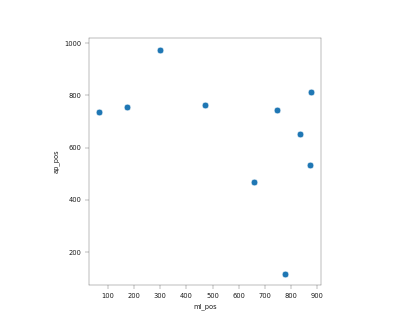

In [187]:
plotd = rfdf[rfdf.datakey=='20190504_JC078_fov1']
fig, ax =pl.subplots()
sns.scatterplot(x='ml_pos', y='ap_pos', data=plotd, ax=ax)
ax.set_aspect('equal')

# Aggregate deviants

In [8]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [9]:
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                             do_spherical_correction=do_spherical_correction)
deviants, no_deviants = sct.aggregate_deviant_cells(response_type=response_type,
                             do_spherical_correction=do_spherical_correction, 
                             meta=meta, traceid=traceid, 
                             create_new=True, redo_fov=True, save_plots=True)
for n in no_deviants:
    print(n)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


('Li', '20190522_JC089_fov1', 'rfs')
('Li', '20190522_JC089_fov1', 'rfs10')
('Li', '20191111_JC120_fov1', 'rfs10')
('Lm', '20190509_JC078_fov1', 'rfs')
('Lm', '20190627_JC091_fov1', 'rfs')
('Lm', '20191111_JC117_fov2', 'rfs10')
('Lm', '20191111_JC120_fov1', 'rfs10')
('V1', '20190504_JC078_fov1', 'rfs')
('V1', '20190509_JC078_fov1', 'rfs')
('V1', '20190512_JC083_fov1', 'rfs')
('V1', '20190517_JC083_fov1', 'rfs')


In [11]:
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    if deviants.query('@va==visual_area and @dk==datakey').empty:
        print(va, dk)

Li 20190522_JC089_fov1
Li 20191111_JC120_fov1
Lm 20190509_JC078_fov1
Lm 20190627_JC091_fov1
Lm 20191111_JC117_fov2
Lm 20191111_JC120_fov1
V1 20190504_JC078_fov1
V1 20190509_JC078_fov1
V1 20190512_JC083_fov1
V1 20190517_JC083_fov1


In [12]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [13]:
# dk='20190509_JC078_fov1'
# va='Lm'
# exp='rfs'
# df0 = sct.do_scatter_analysis(dk, va, experiment=exp, 
#                                 do_gradients=True, do_model=True)

In [15]:
# df0 = sct.load_scatter_results(dk, va, exp, verbose=False)
# df0['reliable']


# Load all results from scatter analysis

In [16]:
excl_v1 =['20190420_JC076_fov1', '20190504_JC078_fov1', '20190508_JC083_fov1', 
          '20190512_JC083_fov1', '20190517_JC083_fov1']
excl_lm = ['20190423_JC076_fov1']
excl_li = ['20190522_JC089_fov1']
exclude = {'V1': excl_v1,
           'Lm':excl_lm,
           'Li': excl_li}

In [17]:
missing_scatter_files=[]
d_list=[]
no_eval=[]
for (va, dk, exp), g in meta.groupby(['visual_area', 'datakey', 'experiment']):
    if dk in exclude[va]:
        print("... ignore %s (%s)" % (dk, va)) # dk)
        continue
    # Load scatter calculations
    df0 = sct.load_scatter_results(dk, va, exp, verbose=False)
    if df0 is None:
        try:
            df0 = sct.do_scatter_analysis(dk, va, experiment=exp, 
                                do_gradients=False, do_model=False)
            assert df_ is not None
        except Exception as e:
            traceback.print_exc()
            missing_scatter_files.append((va, dk, exp))
            continue
    if df0 is None:
        continue
    df_ = df0.copy() 
    # Get deviant or not
    curr_deviants = deviants[(deviants.visual_area==va) 
                          & (deviants.datakey==dk)].copy()
    df_['deviant'] = False
    for dev_cond, dev_vals in curr_deviants.groupby(['axis']):
        dev_rois = dev_vals['deviants'].values
        df_.loc[(df_.axis==dev_cond) \
                & (df_['cell'].isin(dev_rois)), 'deviant'] = True
    df_['visual_area'] = va
    df_['datakey'] = dk
    df_['experiment'] = exp
    d_list.append(df_)
scatterdf = pd.concat(d_list, axis=0)
scatterdf.shape
print("Missing %i datasets:" % (len(missing_scatter_files)))
for m in missing_scatter_files:
    print(m)

... ignore 20190522_JC089_fov1 (Li)
... ignore 20190522_JC089_fov1 (Li)
Do model? False
... loading gradient vectors (20191111_JC120_fov1, Lm)
    found: 20191111_JC120_fov1, Lm dict_keys(['Li', 'Lm'])
    found: 20191111_JC120_fov1, Lm dict_keys(['Li', 'Lm'])
ERROR: no rfs
... ignore 20190504_JC078_fov1 (V1)
... ignore 20190508_JC083_fov1 (V1)
Do model? False
... loading gradient vectors (20190509_JC078_fov1, V1)
    found: 20190509_JC078_fov1, V1 dict_keys(['Lm', 'V1'])
    found: 20190509_JC078_fov1, V1 dict_keys(['Lm', 'V1'])
ERROR: no rfs
... ignore 20190512_JC083_fov1 (V1)
... ignore 20190517_JC083_fov1 (V1)
Missing 0 datasets:


In [19]:
scatterdf['deg_scatter'] = scatterdf['deg_scatter'].abs()
scatterdf['dist_scatter'] = scatterdf['dist_scatter'].abs()

In [20]:
scatterdf[scatterdf.reliable].groupby(['visual_area', 'experiment']).count()

datakey  cell    r2  theta  offset  amplitude  \
visual_area experiment                                                  
Li          rfs             108   108   108    108     108        108   
            rfs10           830   830   830    830     830        830   
Lm          rfs             666   666   666    666     666        666   
            rfs10            82    82    82     82      82         82   
V1          rfs            1172  1172  1172   1172    1172       1172   
            rfs10          1170  1170  1170   1170    1170       1170   

                        aniso_index  ratio_xy  major_axis  minor_axis  ...  \
visual_area experiment                                                 ...   
Li          rfs                 108       108         108         108  ...   
            rfs10               830       830         830         830  ...   
Lm          rfs                 666       666         666         666  ...   
            rfs10                82        82          82          82  ...   
V1          rfs                1172      1172        1172        1172  ...   
            rfs10              1170      1170        1170        1170  ...   

                        vectorproj  ctx_pos  ctx_proj  predicted_ctx_proj  \
visual_area experiment                                                      
Li          rfs                108      108       108                 108   
            rfs10              830      830       830                 830   
Lm          rfs                666      666       666                 666   
            rfs10               82       82        82                  82   
V1          rfs               1172     1172      1172                1172   
            rfs10             1170     1170      1170                1170   

                        predicted_rf_pos  predicted_ctx_pos  deg_scatter  \
visual_area experiment                                                     
Li          rfs                      108                108          108   
            rfs10                    830                830          830   
Lm          rfs                      666                666          666   
            rfs10                     82                 82           82   
V1          rfs                     1172               1172         1172   
            rfs10                   1170               1170         1170   

                        dist_scatter  axis  deviant  
visual_area experiment                               
Li          rfs                  108   108      108  
            rfs10                830   830      830  
Lm          rfs                  666   666      666  
            rfs10                 82    82       82  
V1          rfs                 1172  1172     1172  
            rfs10               1170  1170     1170  

[6 rows x 30 columns]

## Load REGR for retino gradients

In [21]:
r_=[]
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    if dk in exclude[va]:
        continue
    regr_ = sct.load_models(dk, va, return_best=False)
    regr_['visual_area'] = va
    regr_['datakey'] = dk
    r_.append(regr_)
REGR = pd.concat(r_, axis=0)

In [74]:
# Only get ones that pass 
r2_thr=0.5
pass_regr = pd.concat([r for (va, dk), r in REGR.groupby(['visual_area', 'datakey'])\
                       if (r[r.cond=='az']['R2'].values[0]>r2_thr)
                       and (r[r.cond=='el']['R2'].values[0]>r2_thr)])
#### Only include dataset if gradient was well-fit
scatter_pass_regr = pd.concat([g for (va, dk), g in scatterdf[scatterdf['reliable']]\
                    .groupby(['visual_area', 'datakey'])\
           if not pass_regr.query('@va==visual_area and @dk==datakey').empty])\
            .reset_index(drop=True)
# Only get ones that pass 
REGR.shape, pass_regr.shape

((86, 10), (84, 10))

In [75]:
REGR[REGR['R2']<r2_thr]

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond,aligned,visual_area,datakey
0,0.318277,5.233984,0.0,0.56416,0.023876,-18.348327,az,True,Li,20191012_JC113_fov2


<IPython.core.display.Javascript object>


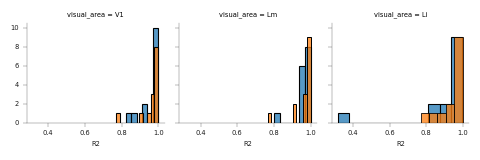

In [76]:
%matplotlib notebook
fg = sns.FacetGrid(REGR, col='visual_area', col_order=visual_areas, 
                  hue='cond', height=2)
fg.map(sns.histplot, 'R2')

In [77]:
scatter_pass_regr['n_cells'] = None
for (va, dk, exp), g in scatter_pass_regr.groupby(['visual_area', 'datakey', 'experiment']):
    n_cells = len(g['cell'].unique())
    scatter_pass_regr.loc[g.index, 'n_cells'] = n_cells

In [78]:
scatter_pass_regr[(scatter_pass_regr.reliable) & (scatter_pass_regr['dist_scatter']>1200)]

,experiment,visual_area,datakey,cell,r2,theta,offset,amplitude,aniso_index,ratio_xy,...,ctx_pos,ctx_proj,predicted_ctx_proj,predicted_rf_pos,predicted_ctx_pos,deg_scatter,dist_scatter,axis,deviant,n_cells
1661,rfs10,Lm,20191111_JC117_fov2,161,0.802231,0.165003,-0.004040,0.071581,-0.197044,1.830629,...,297.280626,621.479948,-925.870366,7.735984,-1586.861994,9.499267,1547.350314,el,False,1
2091,rfs,V1,20190522_JC084_fov1,36,0.802387,0.525307,-0.004778,0.086656,0.285572,0.437802,...,94.484540,548.190720,-1526.010403,-15.893235,-2546.889013,16.816525,2074.201124,el,True,130
2092,rfs,V1,20190522_JC084_fov1,38,0.853112,0.395404,0.004273,-0.056991,0.207934,0.605294,...,159.010568,557.045211,-1734.728863,-15.821447,-2591.135608,18.580491,2291.774075,el,True,130
2103,rfs,V1,20190522_JC084_fov1,64,0.508176,6.249594,-0.006070,0.042724,0.154757,0.731704,...,255.799609,559.973884,-684.087210,-15.797703,-1266.529693,10.086189,1244.061093,el,False,130
2107,rfs,V1,20190522_JC084_fov1,70,0.879235,0.322083,-0.016287,0.582380,0.373427,0.412196,...,308.803131,585.593971,-1924.004982,-15.589989,-2703.046821,20.346500,2509.598953,el,True,130
2111,rfs,V1,20190522_JC084_fov1,76,0.778443,0.407251,-0.002924,0.168261,-0.033199,1.380222,...,188.969080,438.715401,-1377.701962,-16.780803,-1914.525903,14.726551,1816.417363,el,False,130
2114,rfs,V1,20190522_JC084_fov1,79,0.767435,5.933335,-0.004058,0.050105,0.030482,0.932957,...,149.792564,362.804813,-964.438520,-17.396246,-1331.751888,10.760586,1327.243333,el,False,130
2116,rfs,V1,20190522_JC084_fov1,85,0.592390,0.184815,-0.002858,0.041810,0.101951,0.809061,...,131.356556,245.475682,-1700.926087,-18.347488,-2048.946910,15.780395,1946.401769,el,False,130
2173,rfs,V1,20190522_JC084_fov1,187,0.716589,0.434746,0.002084,-0.027396,0.137099,0.711690,...,221.232094,321.370899,-1362.482203,-17.732170,-1712.174429,13.651790,1683.853101,el,False,130
2545,rfs10,V1,20190615_JC097_fov2,7,0.725860,5.655596,-0.003285,0.154652,0.159435,0.590314,...,862.384344,1206.601315,-758.315847,37.935189,-2319.468983,23.697276,1964.917161,az,True,113


In [79]:
scatter_counts = aggr.count_n_cells(scatter_pass_regr, 
            count_cols=['visual_area', 'datakey', 'experiment', 'axis', 'cell'])
scatter_counts.groupby(['visual_area', 'experiment', 'axis']).sum()

n_cells
visual_area experiment axis         
Li          rfs        az         54
                       el         54
            rfs10      az        403
                       el        403
Lm          rfs        az        333
                       el        333
            rfs10      az         41
                       el         41
V1          rfs        az        586
                       el        586
            rfs10      az        585
                       el        585

<IPython.core.display.Javascript object>


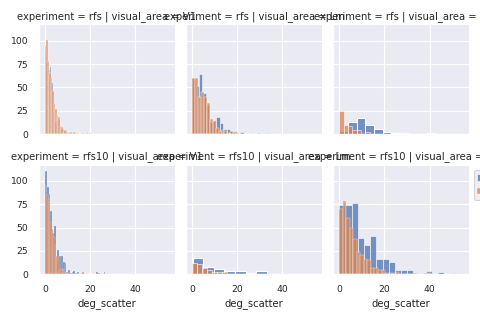

<IPython.core.display.Javascript object>


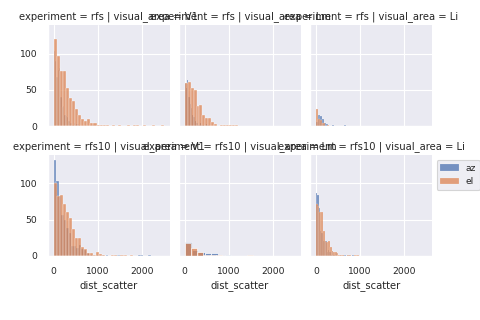

In [80]:
%matplotlib notebook
sns.set(font_scale = 0.75)
fg = sns.FacetGrid(data=scatter_pass_regr, col='visual_area', col_order=visual_areas,
                   hue='axis', row='experiment', row_order=['rfs', 'rfs10'], 
                   height=2)
fg.map(sns.histplot, 'deg_scatter')
pl.legend(bbox_to_anchor=(1,1), loc='upper left')

fg = sns.FacetGrid(data=scatter_pass_regr, col='visual_area', col_order=visual_areas,
                   hue='axis', row='experiment', row_order=['rfs', 'rfs10'], 
                   height=2)
fg.map(sns.histplot, 'dist_scatter')
pl.legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2)


In [81]:
scatter_pass_regr[scatter_pass_regr['dist_scatter']>1200].shape

(25, 33)

In [82]:
scatter_pass_regr[(scatter_pass_regr['dist_scatter']>1200)
                 & (scatter_pass_regr.visual_area=='V1')
                 & (scatter_pass_regr.experiment=='rfs')]

,experiment,visual_area,datakey,cell,r2,theta,offset,amplitude,aniso_index,ratio_xy,...,ctx_pos,ctx_proj,predicted_ctx_proj,predicted_rf_pos,predicted_ctx_pos,deg_scatter,dist_scatter,axis,deviant,n_cells
2091,rfs,V1,20190522_JC084_fov1,36,0.802387,0.525307,-0.004778,0.086656,0.285572,0.437802,...,94.484540,548.190720,-1526.010403,-15.893235,-2546.889013,16.816525,2074.201124,el,True,130
2092,rfs,V1,20190522_JC084_fov1,38,0.853112,0.395404,0.004273,-0.056991,0.207934,0.605294,...,159.010568,557.045211,-1734.728863,-15.821447,-2591.135608,18.580491,2291.774075,el,True,130
2103,rfs,V1,20190522_JC084_fov1,64,0.508176,6.249594,-0.006070,0.042724,0.154757,0.731704,...,255.799609,559.973884,-684.087210,-15.797703,-1266.529693,10.086189,1244.061093,el,False,130
2107,rfs,V1,20190522_JC084_fov1,70,0.879235,0.322083,-0.016287,0.582380,0.373427,0.412196,...,308.803131,585.593971,-1924.004982,-15.589989,-2703.046821,20.346500,2509.598953,el,True,130
2111,rfs,V1,20190522_JC084_fov1,76,0.778443,0.407251,-0.002924,0.168261,-0.033199,1.380222,...,188.969080,438.715401,-1377.701962,-16.780803,-1914.525903,14.726551,1816.417363,el,False,130
2114,rfs,V1,20190522_JC084_fov1,79,0.767435,5.933335,-0.004058,0.050105,0.030482,0.932957,...,149.792564,362.804813,-964.438520,-17.396246,-1331.751888,10.760586,1327.243333,el,False,130
2116,rfs,V1,20190522_JC084_fov1,85,0.592390,0.184815,-0.002858,0.041810,0.101951,0.809061,...,131.356556,245.475682,-1700.926087,-18.347488,-2048.946910,15.780395,1946.401769,el,False,130
2173,rfs,V1,20190522_JC084_fov1,187,0.716589,0.434746,0.002084,-0.027396,0.137099,0.711690,...,221.232094,321.370899,-1362.482203,-17.732170,-1712.174429,13.651790,1683.853101,el,False,130
2869,rfs,V1,20190616_JC097_fov1,3,0.558476,0.115572,-0.003449,0.241361,-0.232849,1.867994,...,1050.852446,1072.079528,2937.335324,-6.361193,2945.375229,18.577455,1865.255796,el,True,98
3396,rfs,V1,20190622_JC085_fov1,60,0.584760,3.243687,-0.000648,0.400911,-0.109459,1.318795,...,903.364384,874.446326,2342.729650,-4.940037,2333.740991,9.656784,1468.283324,el,True,22


### Count fraction deviant per site

In [83]:
count_cols=['visual_area', 'datakey', 'experiment', 'cell']
fit_ = aggr.count_n_cells(scatterdf, name='fit', count_cols=count_cols, reset_index=False)
reliable_ = aggr.count_n_cells(scatterdf[scatterdf['reliable']], name='reliable', 
                               count_cols=count_cols, reset_index=False)
deviants_ = aggr.count_n_cells(scatterdf[scatterdf['deviant']], name='deviant', 
                              count_cols=count_cols, reset_index=False) 
# Get counts
counts0 = fit_.merge(reliable_, left_index=True, right_index=True, how='outer')
count_dev = counts0.merge(deviants_, left_index=True, right_index=True, how='outer')
count_dev = count_dev.fillna(value=0).reset_index()
count_dev['fraction_reliable'] = count_dev['reliable']/count_dev['fit'].astype(float)
count_dev['fraction_deviant'] = count_dev['deviant']/count_dev['fit'].astype(float)

<IPython.core.display.Javascript object>


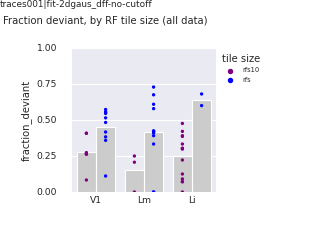

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/ fraction_deviant_alldata


In [84]:
%matplotlib notebook
ymax=1
exp_colors={'rfs': 'blue', 'rfs10': 'purple'}
fig, ax = pl.subplots(figsize=(4,3))
fig.set_facecolor('1')
#exp_colors = {'rfs': [0.7]*3, 'rfs10': [0.4]*3}
# exp_colors = {'rfs': 'blue', 'rfs10': 'purple'}
sns.stripplot(x='visual_area', y='fraction_deviant', data=count_dev, ax=ax,
              hue='experiment', palette=exp_colors, dodge=True, 
              order=visual_areas, jitter=False,size=3)
sns.barplot(x='visual_area', y='fraction_deviant', data=count_dev, ax=ax,
              hue='experiment', palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
              edgecolor='w',ci=None, order=visual_areas)
pplot.crop_legend_labels(ax, 2,start_ix=0, bbox_to_anchor=(1, 1), loc='upper left',
              fontsize=6, title='tile size', markerscale=0.5)
ax.set_box_aspect(1)
ax.set_yticks(np.linspace(0,ymax, 5))
ax.set_ylim([0, ymax])
ax.set_xlabel('')
ax.tick_params(which='both', axis='x', size=0)
sns.despine(bottom=True, offset=4, trim=True)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, "Fraction deviant, by RF tile size (all data)")

figname = 'fraction_deviant_alldata' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


## Get unique datasets

In [85]:
import analyze2p.stats as pstats

In [86]:
bw_colors=dict((v, [0.7]*3) for v in visual_areas)
axis_colors={'az': [0.7]*3,
             'el': [0.5]*3}
exp_colors={'rfs':'blue', 'rfs10': 'purple'}

#### 1 experiment per fov only

In [161]:
min_ncells = 10
f_=[]
for (va, dk), g in scatter_pass_regr[scatter_pass_regr.reliable].groupby(['visual_area', 'datakey']):
#     if va=='Lm' and dk in['20190430_JC078_fov1', '20190508_JC083_fov1']:
#         continue
    if va in ['V1', 'Lm']:
        if 'rfs' in g['experiment'].values:
            df_ = g[g.experiment=='rfs'].copy()
#         elif 'rfs10' in g['experiment'].values:
#             df_ = g[g.experiment=='rfs10'].copy()
    elif va=='Li':
        if 'rfs10' in g['experiment'].values:
            df_ = g[g.experiment=='rfs10'].copy()
#         elif 'rfs' in g['experiment'].values:
#             df_ = g[g.experiment=='rfs'].copy()
    if len(df_['cell'].unique())<min_ncells:
        print("    too few cells: %s, %s (n=%i)" % (va, dk, len(df_['cell'].unique())))
        continue
    df_['n_cells'] = len(df_['cell'].unique())
    # passdf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
    f_.append(df_)
scatter_regr = pd.concat(f_, axis=0)

    too few cells: Li, 20190528_JC092_fov1 (n=9)
    too few cells: Li, 20191111_JC120_fov1 (n=3)
    too few cells: Lm, 20190504_JC078_fov1 (n=7)
    too few cells: Lm, 20190509_JC078_fov1 (n=4)
    too few cells: Lm, 20190627_JC091_fov1 (n=5)
    too few cells: Lm, 20191111_JC117_fov2 (n=5)
    too few cells: V1, 20190501_JC076_fov1 (n=9)


In [162]:
scatter_pass_regr

,experiment,visual_area,datakey,cell,r2,theta,offset,amplitude,aniso_index,ratio_xy,...,ctx_pos,ctx_proj,predicted_ctx_proj,predicted_rf_pos,predicted_ctx_pos,deg_scatter,dist_scatter,axis,deviant,n_cells
0,rfs10,Li,20190527_JC092_fov3,1,0.554930,3.430451,-0.008447,0.113912,-0.050962,1.268702,...,557.789432,525.692541,498.266807,17.179469,519.836486,3.208532,27.425735,az,True,40
1,rfs10,Li,20190527_JC092_fov3,2,0.714423,0.420156,-0.001327,0.089209,-0.034325,1.458072,...,578.730333,545.872315,567.741491,19.540298,598.021431,2.558471,21.869177,az,False,40
2,rfs10,Li,20190527_JC092_fov3,4,0.634111,0.578259,0.001873,0.048070,0.014424,1.366515,...,553.981996,524.137220,523.352114,16.997513,548.971182,0.091849,0.785106,az,False,40
3,rfs10,Li,20190527_JC092_fov3,5,0.882504,0.186008,0.000862,0.145984,-0.124330,1.491622,...,531.137378,498.004560,512.817232,13.940257,540.463664,1.732932,14.812671,az,False,40
4,rfs10,Li,20190527_JC092_fov3,9,0.789373,0.142442,0.000688,0.086568,-0.158003,1.566241,...,470.218395,436.667832,447.633299,6.764483,476.545025,1.282848,10.965467,az,False,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999,rfs10,V1,20191111_JC117_fov1,202,0.511490,0.985464,-0.001010,0.020415,0.117046,1.425612,...,1037.025440,971.644470,938.608018,16.141573,1001.116894,0.314255,33.036453,el,False,20
4000,rfs10,V1,20191111_JC117_fov1,208,0.716884,1.956961,0.001162,0.061106,-0.055381,0.633367,...,836.533855,796.195327,897.144239,14.472637,961.802736,0.960262,100.948912,el,False,20
4001,rfs10,V1,20191111_JC117_fov1,219,0.580318,0.705334,-0.002002,0.055011,0.039205,1.304656,...,509.294716,457.558316,766.889204,11.251400,769.214209,2.942467,309.330887,el,False,20
4002,rfs10,V1,20191111_JC117_fov1,222,0.645544,0.051111,-0.002967,0.043610,-0.296001,1.983681,...,762.789824,669.466585,519.540875,13.267148,672.732996,1.426147,149.925710,el,False,20


In [163]:
scatter_regr.groupby(['visual_area']).count()

,experiment,datakey,cell,r2,theta,offset,amplitude,aniso_index,ratio_xy,major_axis,...,ctx_pos,ctx_proj,predicted_ctx_proj,predicted_rf_pos,predicted_ctx_pos,deg_scatter,dist_scatter,axis,deviant,n_cells
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,782,782,782,782,782,782,782,782,782,782,...,782,782,782,782,782,782,782,782,782,782
Lm,708,708,708,708,708,708,708,708,708,708,...,708,708,708,708,708,708,708,708,708,708
V1,1422,1422,1422,1422,1422,1422,1422,1422,1422,1422,...,1422,1422,1422,1422,1422,1422,1422,1422,1422,1422


In [164]:
# drop duplicates
counts = aggr.count_n_cells(scatter_regr)
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')

finaldf = pd.concat([g for (va, dk), g in scatter_regr.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
print(scatter_regr.shape, finaldf.shape)

(2912, 33) (2282, 33)


In [165]:
k1 = finaldf['datakey'].unique()
k0 = scatter_regr['datakey'].unique()
len(k1), len(k0)

(19, 29)

| visual_area   |   datakey |
|:--------------|----------:|
| Li            |         7 |
| Lm            |         5 |
| V1            |         7 |


<IPython.core.display.Javascript object>


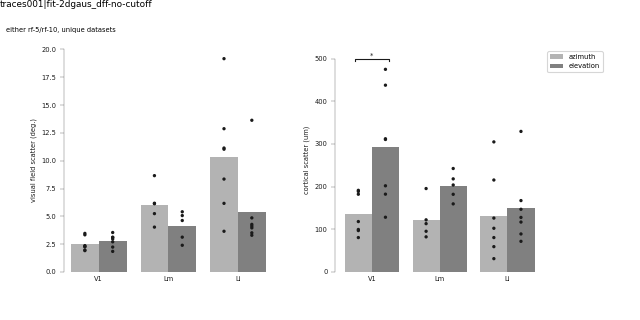

   t_stat    p_val visual_area        metric
0     1.0  0.03125          V1  dist_scatter
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/ scatter_perFOV_reliable


,t_stat,p_val,visual_area,metric
0,10.0,0.578125,V1,deg_scatter
1,0.0,0.062500,Lm,deg_scatter
2,3.0,0.078125,Li,deg_scatter
0,1.0,0.031250,V1,dist_scatter
1,0.0,0.062500,Lm,dist_scatter
2,12.0,0.812500,Li,dist_scatter


In [166]:
plotd = finaldf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()
print(plotd[['visual_area', 'datakey']]\
      .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())
s_=[]
fig, axn = pl.subplots(1,2, figsize=(8, 4))
fig.patch.set_facecolor('w')
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', palette=axis_colors, ci=None)
    sns.stripplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', dodge=True,
              jitter=False, size=3,
              palette=dict((k, 'k') for k in ['az', 'el']))
    ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
                else 'visual field scatter (deg.)'
    ax.set_ylabel(ylabel)
    if metric=='dist_scatter':
        offset=20; h=5;
    else:
        offset=1; h=.1;
    # stats
    stats_ = pstats.paired_ttests(plotd, metric=metric, c1='az', c2='el',
                                        compare_var='axis', ttest=False)
    stats_['metric'] = metric
    s_.append(stats_)
    pplot.annotate_sig_on_paired_plot(ax, plotd, stats_, metric, offset=offset, h=h)
    ax.legend_.remove()
statdf = pd.concat(s_)
# custom legend
leg_h = pplot.custom_legend_markers(colors=[axis_colors['az'], axis_colors['el']],
                                   labels=['azimuth', 'elevation'],
                                    use_patch=True)
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left')

pl.subplots_adjust(left=0.1, right=0.85, wspace=0.3, bottom=0.15, top=0.85)
sns.despine(bottom=True, trim=True)
for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, 'either rf-5/rf-10, unique datasets')
    
figname = 'scatter_perFOV_reliable'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
statdf

<IPython.core.display.Javascript object>


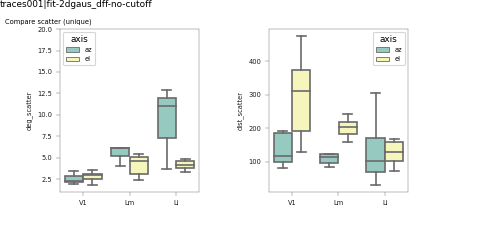

In [167]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))
ax=axn[0]
sns.boxplot(x='visual_area', y='deg_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3', fliersize=0, ax=ax)
ax=axn[1]
sns.boxplot(x='visual_area', y='dist_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3', fliersize=0, ax=ax)
for ax in axn:
    ax.set_xlabel('')
pl.subplots_adjust(bottom=0.2, right=0.85, wspace=0.5)
fig.text(0.01, 0.9, 'Compare scatter (unique)')
pplot.label_figure(fig, data_id)


## Check paired

In [168]:
importlib.reload(pplot)
%matplotlib inline
# sns.set_style('white')
sns.reset_orig()# 'white')
# sns.set(font_scale = 0.8)
pplot.set_plot_params()

   t_stat  p_val visual_area        metric
0     1.0  0.031          V1  dist_scatter
|    |   t_stat |   p_val | visual_area   | metric       |
|---:|---------:|--------:|:--------------|:-------------|
|  0 |       10 |   0.578 | V1            | deg_scatter  |
|  1 |        0 |   0.062 | Lm            | deg_scatter  |
|  2 |        3 |   0.078 | Li            | deg_scatter  |
|  0 |        1 |   0.031 | V1            | dist_scatter |
|  1 |        0 |   0.062 | Lm            | dist_scatter |
|  2 |       12 |   0.812 | Li            | dist_scatter |


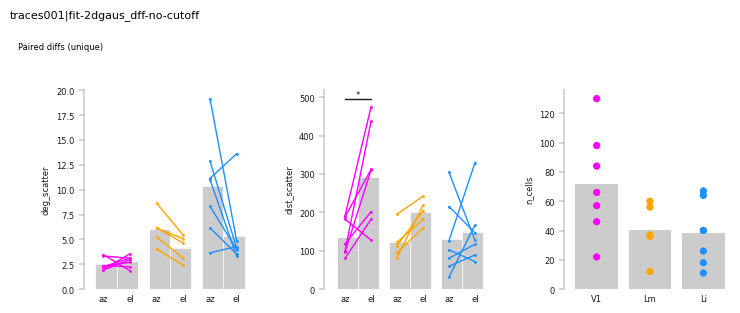

In [169]:
plotd = finaldf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

# Paired: spstats.wilcoxon()
offset=2
fig, axn = pl.subplots(1,3, figsize=(8, 4))
fig.patch.set_facecolor('w')

s_=[]
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    ax, stats_ = pplot.pairwise_compare_single_metric(plotd, 
                 curr_metric=metric, ax=ax, size=1,
                 c1='az', c2='el', compare_var='axis', label_areas=False,
                 ttest=False, return_stats=True, bar_ci=None, 
                 facecolor=[0.8]*3, edgecolor='w')
    stats_['metric'] = metric
    if metric=='dist_scatter':
        offset=20; h=2;
    else:
        offset=1; h=.1;
    pplot.annotate_sig_on_paired_plot(ax, plotd, stats_, metric, offset=offset, h=h)
    s_.append(stats_)
    ax.set_xlabel('')
statsdf = pd.concat(s_)
print(statsdf.to_markdown())
fig.text(0.01, 0.9, 'Paired diffs (unique)')

ax=axn[-1]
countd_ = plotd[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
sns.barplot(x='visual_area', y='n_cells', data=plotd, ax=ax,
            order=visual_areas, color=[0.8]*3, ci=None)
sns.stripplot(x='visual_area', y='n_cells', data=plotd, ax=ax,
            order=visual_areas, palette=area_colors, hue='visual_area',
              jitter=False, dodge=False)
ax.tick_params(which='both', axis='x', size=0)
ax.legend_.remove()
ax.set_xlabel('')

pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, bottom=0.3, top=0.8)

pplot.label_figure(fig, data_id)
figname = 'scatter_perFOV_paired_reliable'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [170]:
plotd[plotd.visual_area=='Li']

,visual_area,datakey,axis,cell,r2,theta,offset,amplitude,aniso_index,ratio_xy,...,vectorproj,ctx_pos,ctx_proj,predicted_ctx_proj,predicted_rf_pos,predicted_ctx_pos,deg_scatter,dist_scatter,deviant,n_cells
0,Li,20190527_JC092_fov3,az,68.125000,0.750627,3.271396,-0.002160,0.118389,-0.148180,1.489346,...,13.765084,428.003444,402.020574,419.633099,2.711106,441.311215,3.659012,31.276326,0.225000,40.0
1,Li,20190527_JC092_fov3,el,68.125000,0.750627,3.271396,-0.002160,0.118389,-0.148180,1.489346,...,4.695170,791.365636,571.154504,443.456248,-1.666389,658.884010,4.279085,167.329791,0.150000,40.0
2,Li,20190602_JC091_fov1,az,136.746269,0.691993,2.856871,-0.005986,0.108680,-0.145887,1.399238,...,14.087472,389.864439,985.476433,916.461281,30.965115,381.717897,11.031686,102.464542,0.417910,67.0
3,Li,20190602_JC091_fov1,el,136.746269,0.691993,2.856871,-0.005986,0.108680,-0.145887,1.399238,...,5.545347,934.973882,76.687199,47.925760,-6.038668,855.566260,3.300792,71.878261,0.253731,67.0
4,Li,20190612_JC099_fov1,az,159.850000,0.762558,3.830942,-0.006026,0.107078,-0.161192,1.680484,...,16.756579,273.469119,518.475248,489.247085,19.567489,283.079260,6.167592,59.405130,0.300000,40.0
5,Li,20190612_JC099_fov1,el,159.850000,0.762558,3.830942,-0.006026,0.107078,-0.161192,1.680484,...,4.699454,656.033816,241.535947,171.872739,-0.035840,563.399804,3.520386,89.149784,0.225000,40.0
6,Li,20190614_JC091_fov1,az,233.359375,0.725476,3.445508,-0.005130,0.093062,-0.127550,1.504867,...,13.450254,517.127202,1014.668470,937.238535,18.742240,224.302556,11.138547,126.347725,0.375000,64.0
7,Li,20190614_JC091_fov1,el,233.359375,0.725476,3.445508,-0.005130,0.093062,-0.127550,1.504867,...,5.987391,900.015656,141.806608,471.229020,-19.149115,1059.882132,13.633238,329.422411,0.375000,64.0
8,Li,20190617_JC099_fov1,az,40.818182,0.687081,4.799609,-0.004949,0.062416,-0.180230,1.880123,...,16.705614,494.101405,719.543592,726.585242,7.296524,497.167029,8.349179,80.650332,0.090909,11.0
9,Li,20190617_JC099_fov1,el,40.818182,0.687081,4.799609,-0.004949,0.062416,-0.180230,1.880123,...,6.018856,713.557303,28.519122,32.924833,-10.877010,725.079831,3.964516,117.029875,0.090909,11.0


In [171]:
'20191017_JC113_fov1'

'20191017_JC113_fov1'

# Cortical magnification

In [172]:
import analyze2p.stats as pstats
import statsmodels.api as sm
import pingouin as pg

In [173]:
regr_df = pd.concat([g for (va, dk), g in pass_regr.groupby(['visual_area', 'datakey'])\
                     if (va, dk) in u_dkeys])
print(regr_df[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())
regr_df['cortical_mag'] = np.abs(1./regr_df['coefficient'])

|    |   visual_area |
|:---|--------------:|
| Li |             7 |
| V1 |             7 |
| Lm |             5 |


In [174]:
cmag_df = regr_df[['visual_area','datakey']].drop_duplicates().reset_index(drop=True)
cmag_df['cortical_mag'] = None
cmag_df['cortical_mag_ratio'] = None
for (va, dk), cg in cmag_df.groupby(['visual_area', 'datakey']):
    r_df = regr_df[(regr_df.visual_area==va) & (regr_df.datakey==dk)].copy()
    mean_mag = r_df['coefficient'].abs().mean()
    ratio_mag = float(r_df[r_df.cond=='el']['cortical_mag'])\
                /float(r_df[r_df.cond=='az']['cortical_mag'])
    cmag_df.loc[cg.index, 'cortical_mag'] = mean_mag
    cmag_df.loc[cg.index, 'cortical_mag_ratio'] = ratio_mag
cmag_df['cortical_mag'] = abs(cmag_df['cortical_mag'].astype(float))
cmag_df['cortical_mag_ratio'] = abs(cmag_df['cortical_mag_ratio'].astype(float))

In [175]:
regr_df.groupby('visual_area')['cortical_mag'].describe()

,count,mean,std,min,25%,50%,75%,max
visual_area,,,,,,,,
Li,14.0,20.207700,10.189448,8.547751,10.080576,19.259762,26.049449,39.104102
Lm,10.0,37.029783,23.091996,14.118507,18.855274,32.760729,46.878781,90.836350
V1,14.0,77.643790,33.286887,34.936167,51.023939,68.272754,97.848050,152.046821


In [176]:
regr_df.groupby(['visual_area', 'cond'])['cortical_mag'].describe()

count        mean        std        min        25%  \
visual_area cond                                                       
Li          az      7.0   11.588435   3.350401   8.547751   9.460011   
            el      7.0   28.826965   6.354628  21.776068  24.743524   
Lm          az      5.0   20.588361   6.711421  14.118507  18.190451   
            el      5.0   53.471206  21.884848  33.643751  44.071915   
V1          az      7.0   54.266435  15.129335  34.936167  50.191802   
            el      7.0  101.021144  29.943915  67.251153  79.736877   

                         50%         75%         max  
visual_area cond                                      
Li          az      9.659672   13.624072   16.743455  
            el     26.291309   32.565113   39.104102  
Lm          az     18.332977   20.422164   31.877706  
            el     47.814403   50.989609   90.836350  
V1          az     50.524800   54.512434   84.995607  
            el    100.404267  113.986008  152.046821

<IPython.core.display.Javascript object>


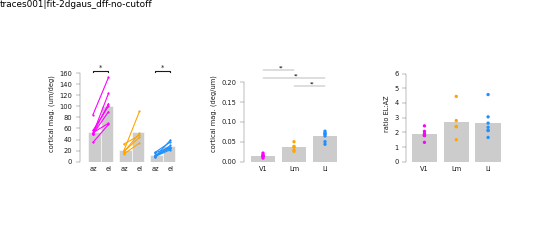

Cortical Mag. (um/deg):
 |    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        0 |   0.016 | V1            |
|  1 |        0 |   0.062 | Lm            |
|  2 |        0 |   0.016 | Li            |
   t_stat  p_val visual_area
2     0.0  0.016          Li
   t_stat  p_val visual_area
0     0.0  0.016          V1
Other stats
 |    | Contrast    | A   | B   | Paired   | Parametric   |   U-val | Tail      |      p-unc |     p-corr | p-adjust   |     hedges | metric             |
|---:|:------------|:----|:----|:---------|:-------------|--------:|:----------|-----------:|-----------:|:-----------|-----------:|:-------------------|
|  0 | visual_area | Li  | Lm  | False    | False        |      34 | one-sided | 0.00468306 | 0.00468306 | fdr_bh     |  2.28676   | cortical_mag       |
|  1 | visual_area | Li  | V1  | False    | False        |      49 | one-sided | 0.00108251 | 0.00324754 | fdr_bh     |  5.08387   | cortical_mag       |
|  2 | vis

In [177]:
%matplotlib notebook
s_=[]
fig, axn = pl.subplots(1,3, figsize=(7,3))
fig.patch.set_facecolor('w')
ax=axn[0]
metric='cortical_mag'
ax, stats_ = pplot.pairwise_compare_single_metric(regr_df, 
                 curr_metric=metric, ax=ax, size=1,
                 c1='az', c2='el', compare_var='cond', 
                 ttest=False, return_stats=True, bar_ci=None,
                 facecolor=[0.8]*3, edgecolor='w', label_areas=False)
print('Cortical Mag. (um/deg):\n',stats_.to_markdown())
pl.subplots_adjust(bottom=.2)
pplot.annotate_sig_on_paired_plot(ax, regr_df, stats_, metric, offset=10, h=2)
# pplot.crop_legend_labels(ax, 2, start_ix=2, markerscale=0.1, 
#                         bbox_to_anchor=(1,1), loc='upper right', fontsize=6)
ax.set_box_aspect(1)
ax.tick_params(which='both', axis='x', size=0)
sns.despine(bottom=True, trim=True, ax=ax)
ylabel = 'cortical mag. (um/deg)' 
ax.set_ylabel(ylabel)

for ai, metric in enumerate(['cortical_mag', 'cortical_mag_ratio']):
    ax=axn[ai+1]
    ymax=0.2 if metric=='cortical_mag' else 5.5
    ylim = (0, ymax+0.04) if metric=='cortical_mag' else (0, ymax+1)
    pplot.stripplot_metric_by_area(cmag_df, metric, area_colors=area_colors,
                                markersize=3, ax=ax,
                                sig_fontsize=4, jitter=False, ylim=ylim,
                                plot_means=True, y_loc=ymax-0.01, offset=0.02,
                                mean_style='bar', mean_type='mean', aspect=2)
    stats = pg.pairwise_ttests(dv=metric, between='visual_area', data=cmag_df,
                           subject='datakey', tail='one-sided', # use one-talied bec pos
                           padjust='fdr_bh', parametric=False)
    stats['metric'] = metric
    s_.append(stats)
    if metric=='cortical_mag_ratio':
        ylabel='ratio EL:AZ'
    else:
        ylabel = 'cortical mag. (deg/um)'
    ax.set_ylabel(ylabel)
statsdf = pd.concat(s_)
print('Other stats\n',statsdf.to_markdown())

for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.85, wspace=0.7)
pplot.label_figure(fig, data_id)

pl.savefig(os.path.join(dst_dir, 'cortical_magnification_reliable.svg'))
print(dst_dir)

# Check rfs-5 vs rfs-10

In [134]:
# Check all dsets that pass_regr (non-unique), PAIRED
min_ncells=5
scatter_pass = scatter_pass_regr[scatter_pass_regr['n_cells']>=min_ncells]

In [135]:
has_rfs5_andrfs10 = pd.concat([g for (va, dk), g \
                        in scatter_pass_regr.groupby(['visual_area', 'datakey'])
                        if 'rfs' in g['experiment'].values \
                               and 'rfs10' in g['experiment'].values])
has_both_counts =pd.concat([g for (va, dk), g in count_dev.groupby(['visual_area', 'datakey'])
                        if 'rfs' in g['experiment'].values \
                               and 'rfs10' in g['experiment'].values])

In [136]:
# sns.set(font_scale = 0.8)
pplot.set_plot_params()

<IPython.core.display.Javascript object>


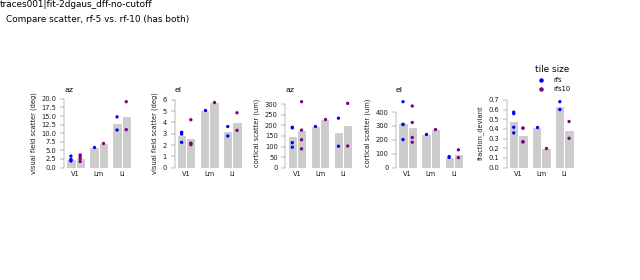

   t_stat  p_val visual_area
0     0.0  0.125          V1
1     0.0  1.000          Lm
2     0.0  0.500          Li


In [137]:
exp_colors = {'rfs': 'blue', 'rfs10': 'purple'}

plotd_exp = has_rfs5_andrfs10.groupby(['visual_area', 'datakey', 'axis', 'experiment'])\
                .mean().reset_index()
# print(plotd[['visual_area', 'datakey']]\
#       .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())
stats_list=[]
fig, axn = pl.subplots(1,5, figsize=(8, 3.5))
fig.patch.set_facecolor('w')
ai=0
for mi, metric in enumerate(['deg_scatter', 'dist_scatter']):
    for ei, (exp, exp_df) in enumerate(plotd_exp.groupby('axis')):
        ax=axn[ai]
        ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
                    else 'visual field scatter (deg)'
        ax.set_title(exp, loc='left', fontsize=7)
        sns.barplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', 
                    palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
                    edgecolor='w', ci=None)
        sns.stripplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', dodge=True,
                  jitter=False, size=3,
                  palette=exp_colors)
        ax.legend_.remove()
        ax.set_box_aspect(1)
        ax.set_ylabel(ylabel)
        if metric=='dist_scatter':
            offset=100; h=20;
            #ax.set_ylim([0, 550])
        else:
            #ax.set_ylim([0, 20])
            offset=10; h=.1;
        ai+=1
        try:
            stats_ = pstats.paired_ttests(exp_df, metric=metric, c1='rfs', c2='rfs10',
                                    compare_var='experiment', ttest=False)
            stats_['metric'] = metric
            stats_list.append(stats_)
            pplot.annotate_sig_on_paired_plot(ax, exp_df, stats_, 
                                              metric, offset=offset, h=h)
        except Exception as e:
            continue
statdf = pd.concat(stats_list, axis=0)
    
ax=axn[-1]
sns.stripplot(x='visual_area', y='fraction_deviant', data=has_both_counts, ax=ax,
              hue='experiment', palette=exp_colors, dodge=True, 
              order=visual_areas, jitter=False,size=3)
sns.barplot(x='visual_area', y='fraction_deviant', data=has_both_counts, ax=ax,
              hue='experiment', palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
             edgecolor='w',ci=None, order=visual_areas)
pplot.crop_legend_labels(ax, 2,start_ix=0, bbox_to_anchor=(1, 1), loc='upper left',
        fontsize=6, title='tile size', markerscale=0.5)
stats_ = pstats.paired_ttests(has_both_counts, metric='fraction_deviant', 
                              c1='rfs', c2='rfs10',
                              compare_var='experiment', ttest=False)
# stats_['metric'] = metric
ax.set_box_aspect(1)
print(stats_)
pplot.annotate_sig_on_paired_plot(ax, has_both_counts, stats_, 'fraction_deviant', 
                                  offset=0.05, h=0.05)


pl.subplots_adjust(left=0.1, right=0.8, wspace=0.2, bottom=0.2, top=0.85)
sns.despine(bottom=True, trim=True)
for ax in axn.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')  

# custom legend
leg_h = pplot.custom_legend_markers(colors=[exp_colors['rfs'], exp_colors['rfs10']],
                                   labels=['rfs', 'rfs10'],
                                   markers='o', lws=0)
axn[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), frameon=False,
                    loc='lower right', fontsize=6, markerscale=0.5, title='tile size')

fig.text(0.01, 0.92, 'Compare scatter, rf-5 vs. rf-10 (has both)', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, wspace=0.6)

pplot.label_figure(fig, data_id)

figname = 'scatter_compare_rf5-rf10_reliable_paired'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [139]:
# Check all dsets that pass_regr (non-unique), UNAIRED
has_either = scatter_pass.copy()
has_either_counts = count_dev.copy()

<IPython.core.display.Javascript object>


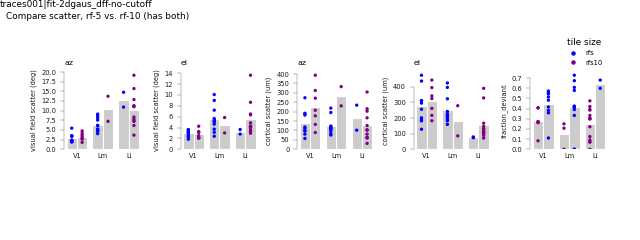

In [114]:
exp_colors = {'rfs': 'blue', 'rfs10': 'purple'}

plotd_exp = has_either.groupby(['visual_area', 'datakey', 'axis', 'experiment'])\
                .mean().reset_index()

fig, axn = pl.subplots(1,5, figsize=(8, 3))
fig.patch.set_facecolor('w')
ai=0
for mi, metric in enumerate(['deg_scatter', 'dist_scatter']):
    for ei, (exp, exp_df) in enumerate(plotd_exp.groupby('axis')):
        ax=axn[ai]
        ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
                    else 'visual field scatter (deg)'
        ax.set_title(exp, loc='left', fontsize=7)
        sns.barplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', hue_order=['rfs', 'rfs10'],
                  palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
                  edgecolor='w', ci=None)
        sns.stripplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', hue_order=['rfs', 'rfs10'],
                  dodge=True, jitter=False, size=3,
                  palette=exp_colors)
        ax.legend_.remove()
        ax.set_box_aspect(1)
        ax.set_ylabel(ylabel)
        if metric=='dist_scatter':
            offset=100; h=20;
            #ax.set_ylim([0, 550])
        else:
            #ax.set_ylim([0, 20])
            offset=10; h=.1;
        ai+=1
    
ax=axn[-1]
sns.stripplot(x='visual_area', y='fraction_deviant', data=has_either_counts, ax=ax,
              hue='experiment', palette=exp_colors, dodge=True, 
              order=visual_areas, jitter=False,size=3)
sns.barplot(x='visual_area', y='fraction_deviant', data=has_either_counts, ax=ax,
              hue='experiment', palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
             edgecolor='w',ci=None, order=visual_areas)
pplot.crop_legend_labels(ax, 2,start_ix=0, bbox_to_anchor=(1, 1), loc='upper left',
        fontsize=6, title='tile size', markerscale=0.5)

# stats_['metric'] = metric
ax.set_box_aspect(1)
# print(stats_)
# pplot.annotate_sig_on_paired_plot(ax, has_either_counts, stats_, 'fraction_deviant', 
#                                   offset=0.05, h=0.05)
sns.despine(bottom=True, trim=True)
for ax in axn.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')  

# custom legend
leg_h = pplot.custom_legend_markers(colors=[exp_colors['rfs'], exp_colors['rfs10']],
                                   labels=['rfs', 'rfs10'],
                                   markers='o', lws=0)
axn[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), frameon=False,
                    loc='lower right', fontsize=6, markerscale=0.5, title='tile size')

fig.text(0.01, 0.92, 'Compare scatter, rf-5 vs. rf-10 (has both)', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, wspace=0.5)

pplot.label_figure(fig, data_id)

figname = 'scatter_compare_rf5-rf10_reliable_unpaired'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [115]:
# currd = has_either[has_either.inbounds]\
#             .groupby(['visual_area', 'datakey', 'axis', 'experiment'])\
#             .mean().reset_index()
    
# test = currd\
#     .groupby(['visual_area', 'datakey', 'axis', 'experiment']).mean().reset_index()
# test

plotd_exp = has_rfs5_andrfs10.groupby(['visual_area', 'datakey', 'axis', 'experiment'])\
                .mean().reset_index()

<IPython.core.display.Javascript object>


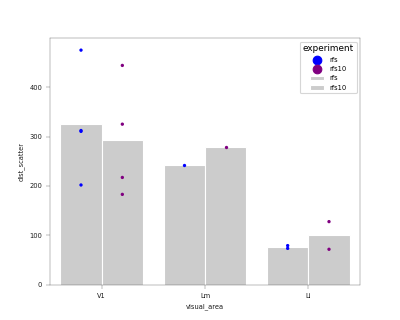

<AxesSubplot:xlabel='visual_area', ylabel='dist_scatter'>

In [116]:
fig, ax  = pl.subplots()
plotd = plotd_exp[plotd_exp.axis=='el']
sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
          order=visual_areas, hue='experiment', hue_order=['rfs', 'rfs10'],
          palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
          edgecolor='w', ci=None)
sns.stripplot(x='visual_area', y=metric, data=plotd, ax=ax,
          order=visual_areas, hue='experiment', hue_order=['rfs', 'rfs10'],
          dodge=True, jitter=False, size=3,
          palette=exp_colors)

In [100]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# #perform two-way ANOVA
# model = ols('deg_scatter ~ C(visual_area) + C(axis) + C(visual_area):C(axis)', \
#             data=plotd).fit()
# sm.stats.anova_lm(model, typ=2)
